Goal of this iteration is to learn an accurate predictive model of all input variables, in as little wall clock time as possible

- Use a better optimiser (ADAM)


In [6]:
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

env = gym.make('CartPole-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 0
torch.manual_seed(SEED)


Action Space:  Discrete(2)
Obs Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [60]:
# Input -> state, action

# Output (all_preds)
# reward_model(state, action) -> reward
# env_model(state, action) -> next_state, done
# q_value(state, action) -> val
# policy(state) -> next_action

W1 = torch.normal(0,1,size=(5,1)) # reward (1), next_state (4), done (1), val (1), next_action (1)
b1 = torch.normal(0,1,size=(1,1)).reshape(-1) # reward (1), next_state (4), done (1), val (1), next_action (1)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam([W1, b1], lr=0.001, amsgrad=False)
# optimizer = torch.optim.SGD([W], lr=0.1)

params = [W1, b1]

for p in params:
    p.requires_grad = True


In [99]:
torch.save({'W1': W1, 'b1': b1}, 'model.pth')


In [92]:
import random
next_state, info = env.reset(seed=SEED)
# next_action = env.action_space.sample()
next_action = random.choice([0, 1])




action_buffer = []


# Logging
episode_reward = []
action_losses = []
action_losses_avg = []
episode_lens = []
episode_step = 0

In [62]:
def custom_reward(next_state, reward, terminated, truncated, info):
    if terminated or truncated:
        return -1
    else:
        return 0

In [97]:
for _ in range(100000):
    # Combine state, action, reward from current and past experince
    state = next_state
    action = next_action

    x = torch.zeros(size=(1,5)) # 4 obs, 1 action,
    x[0,:4] = torch.tensor(state, dtype=torch.float32)
    x[0,4] = torch.tensor([action], dtype=torch.float32)

    # forward pass - make prediction
    y = x @ W1 + b1

    # extract

    p_action = torch.distributions.bernoulli.Bernoulli(torch.sigmoid(y))
    next_action = p_action.sample()
    log_prob = p_action.log_prob(next_action)
    next_action = (next_action - 0.5)*2
    action_buffer.append(-log_prob)
 
    # Enviroment step
    if int(action) == -1:
        a = 0
    else:
        a = 1
    next_state, reward, terminated, truncated, info = env.step(a)

    if episode_step > 40:
        reward = 1
        done = True

    elif terminated or truncated:
        reward = -1
        done = True
    else:
        reward = 0
        done = False

    #backward pass

    # Update action model
    if reward != 0:
        optimizer.zero_grad()
        action_losses_avg.append(torch.mean(torch.tensor(action_buffer)))
        action_buffer = torch.cat(action_buffer)
        action_buffer *= reward
        action_loss = torch.sum(action_buffer)
        action_loss.backward()

        action_buffer = []

        optimizer.step()

    # Logging
    episode_step += 1

    action_losses.append(-log_prob.item())

    # print(f"state_loss: {state_loss.itStepem():0.6f}")

    # Done checking
    if done:
        episode_reward.append(reward)
        episode_lens.append(episode_step)
        episode_step = 0
        next_state, info = env.reset(seed=SEED)


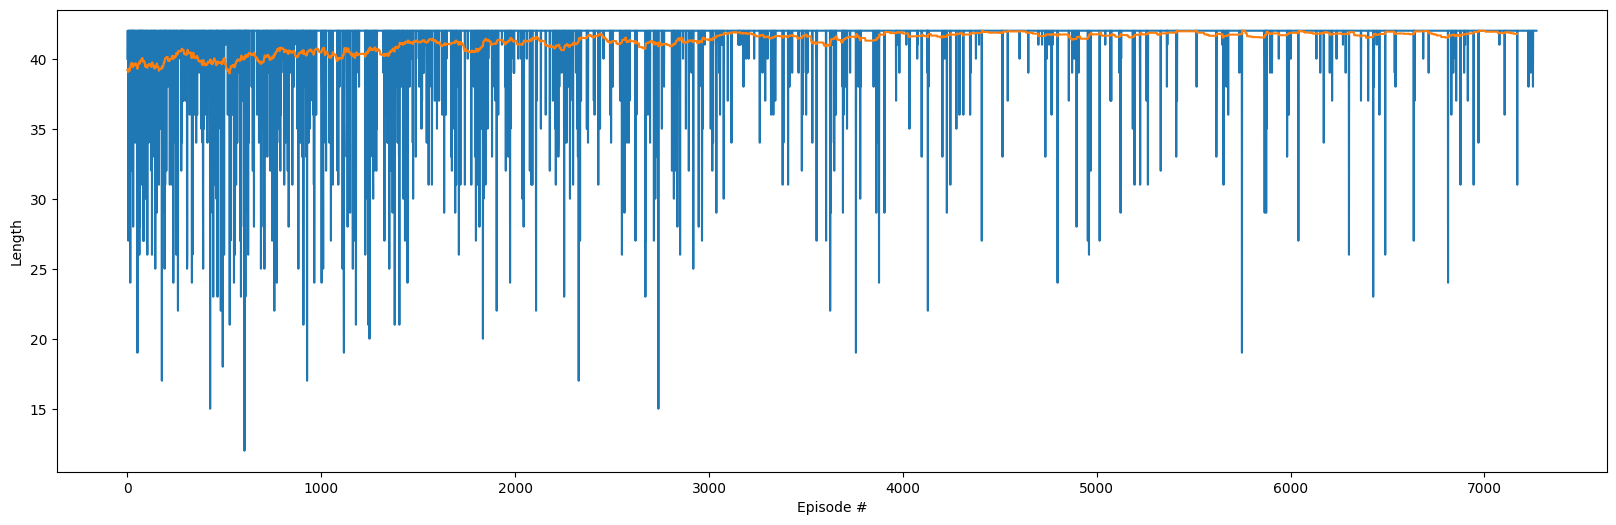

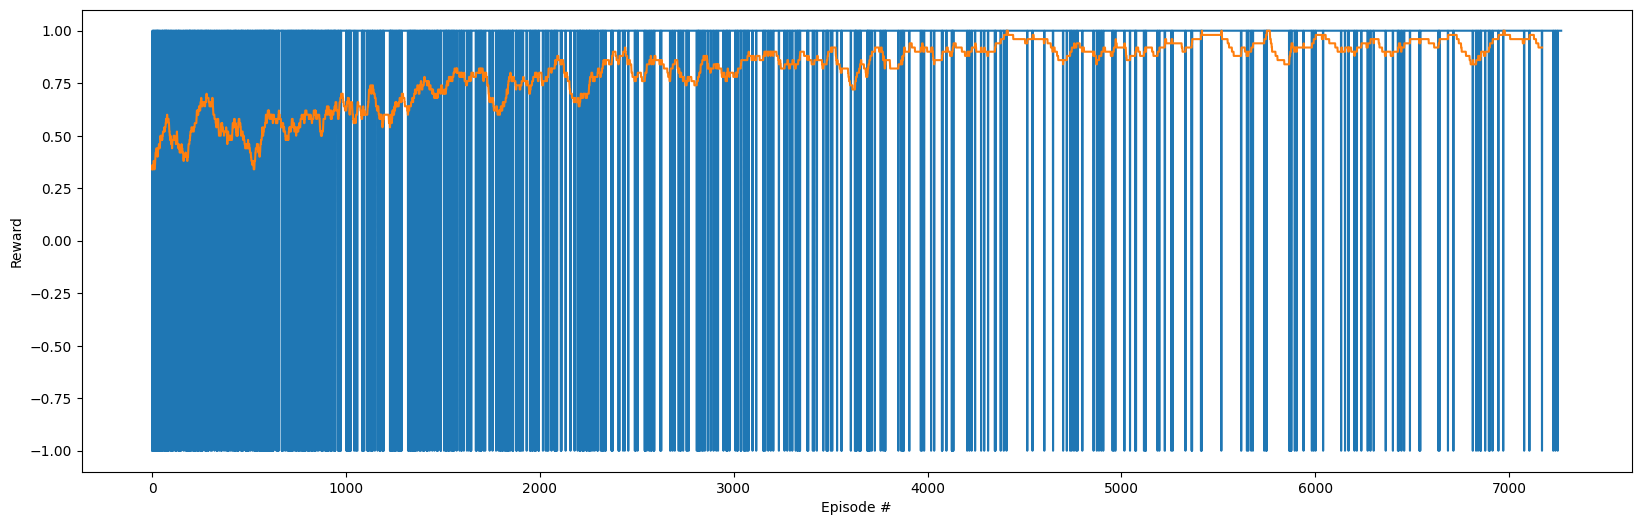

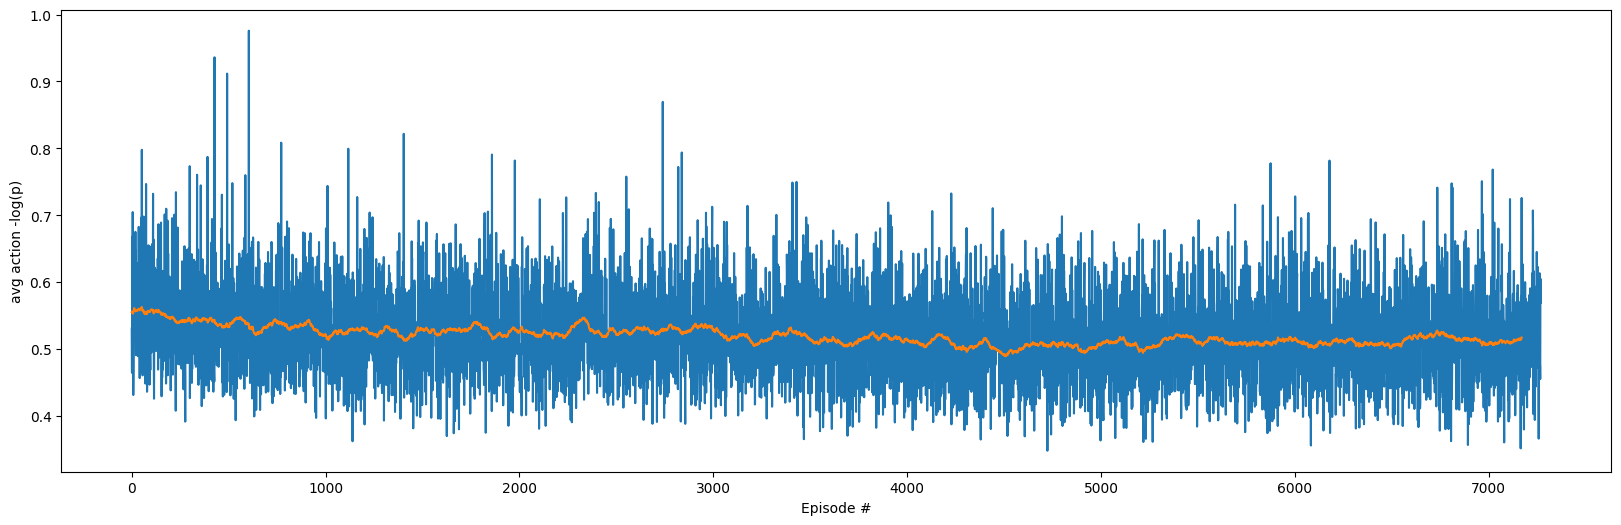

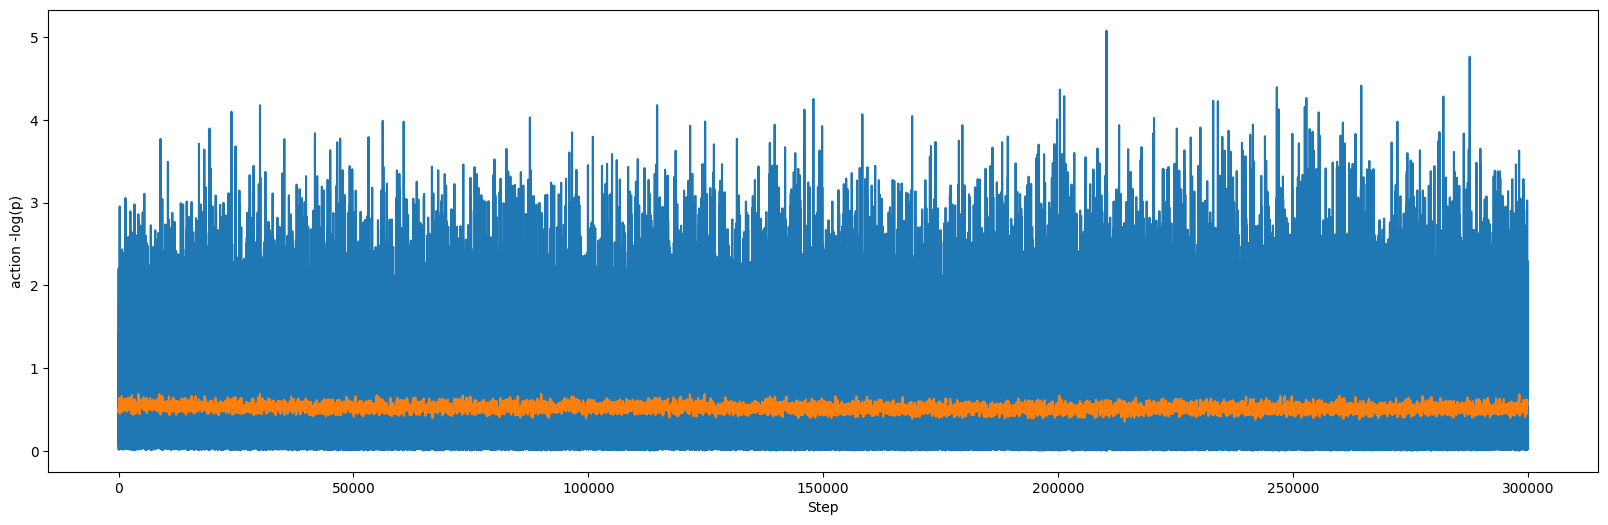

In [98]:


def smooth(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(episode_lens)
plt.plot(smooth(episode_lens,100))
plt.xlabel('Episode #')
plt.ylabel('Length')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(episode_reward)
plt.plot(smooth(episode_reward,100))
plt.xlabel('Episode #')
plt.ylabel('Reward')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(action_losses_avg)
plt.plot(smooth(action_losses_avg,100))
plt.xlabel('Episode #')
plt.ylabel('avg action -log(p)')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(action_losses)
plt.plot(smooth(action_losses,100))
plt.xlabel('Step')
plt.ylabel('action -log(p)')
plt.show()


In [43]:
env.close()